# `IV. Convergence` 
This .pynb file reads `./inter_results/field_result.pkl` generated by `./II_Field_Simulation.ipynb`, and analyzes the field distribution result. This analysis can be specific according to your own need. Here, as an example, we focus on multipole expansion coefficient. 

## (1) import electric field and set parameters for it.

In [1]:
import sys
sys.path.append('../../Electrodes')
import pickle
# add multipoles package path

from multipoles import MultipoleControl
from plottingfuncns import *

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
#module_path = os.path.dirname(os.path.abspath(__file__))
module_path = os.path.abspath('')

In [2]:
###### setting up multipole expansion @ trap location #######
#xl, yl, zl define the origin at which we will do the multipole expansion
#i.e. they define where you want to trap

#strs are the string names of your DC electrodes (copy from loading pickle,
#I wrote it a second time so that the code runs in case you comment out that code)
strs = "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 DC11 DC12 DC13 DC14 DC15 DC16 DC17 DC18 DC19 DC20 RF".split()
zl = 0*1e-3
xl = 0*1e-3
yl = 50*1e-3

position = [xl, yl, zl]
r0 = position
#ROI = 'range of interest', I believe
#It defines the volume region over which multipole expansion will be performed.
#nROI is the number of points that make up the dimensions of the volume of the ROI
#I believe it ends up being the indices of the 3-d array that you index so it is dimensionless
nROI = 10
roi = [nROI, nROI, nROI]
order = 3

excl = {
    # "DC6": "gnd",
    #     "DC4": "gnd",
        # "DC5": "gnd",
    #     "DC8": "gnd",
    #     "DC14": "DC13",
        # "DC11": "gnd",
        # "DC12": "gnd",
    "DC1": "gnd",
    "DC19": "gnd",
    "RF":"gnd"
}
sim_list = ['1','2','4','5','7']

In [3]:
path = module_path+'/inter_results/field_result_'+sim_list[len(sim_list)-1]+'.pkl'
f = open(path, 'rb')
trap = pickle.load(f)
controlled_electrodes = []
for electrode in strs:
    if electrode in excl and excl[electrode] != "gnd":
        trap['electrodes'][excl[electrode]]["potential"] = trap['electrodes'][excl[electrode]]["potential"] + \
                                                           trap['electrodes'][electrode]["potential"]
    elif electrode not in excl:
        controlled_electrodes.append(electrode)
used_order1multipoles = ['Ex', 'Ey', 'Ez']
used_order2multipoles = ['U1', 'U2', 'U3','U4','U5']
used_multipoles = used_order1multipoles + used_order2multipoles

sfinal = MultipoleControl(trap, position, roi, controlled_electrodes, used_multipoles, order)

/home/sqip/Documents/github/bem/examples/document/inter_results/field_result_1.pkl
/home/sqip/Documents/github/bem/examples/document/inter_results/field_result_2.pkl
/home/sqip/Documents/github/bem/examples/document/inter_results/field_result_4.pkl
/home/sqip/Documents/github/bem/examples/document/inter_results/field_result_5.pkl
/home/sqip/Documents/github/bem/examples/document/inter_results/field_result_7.pkl


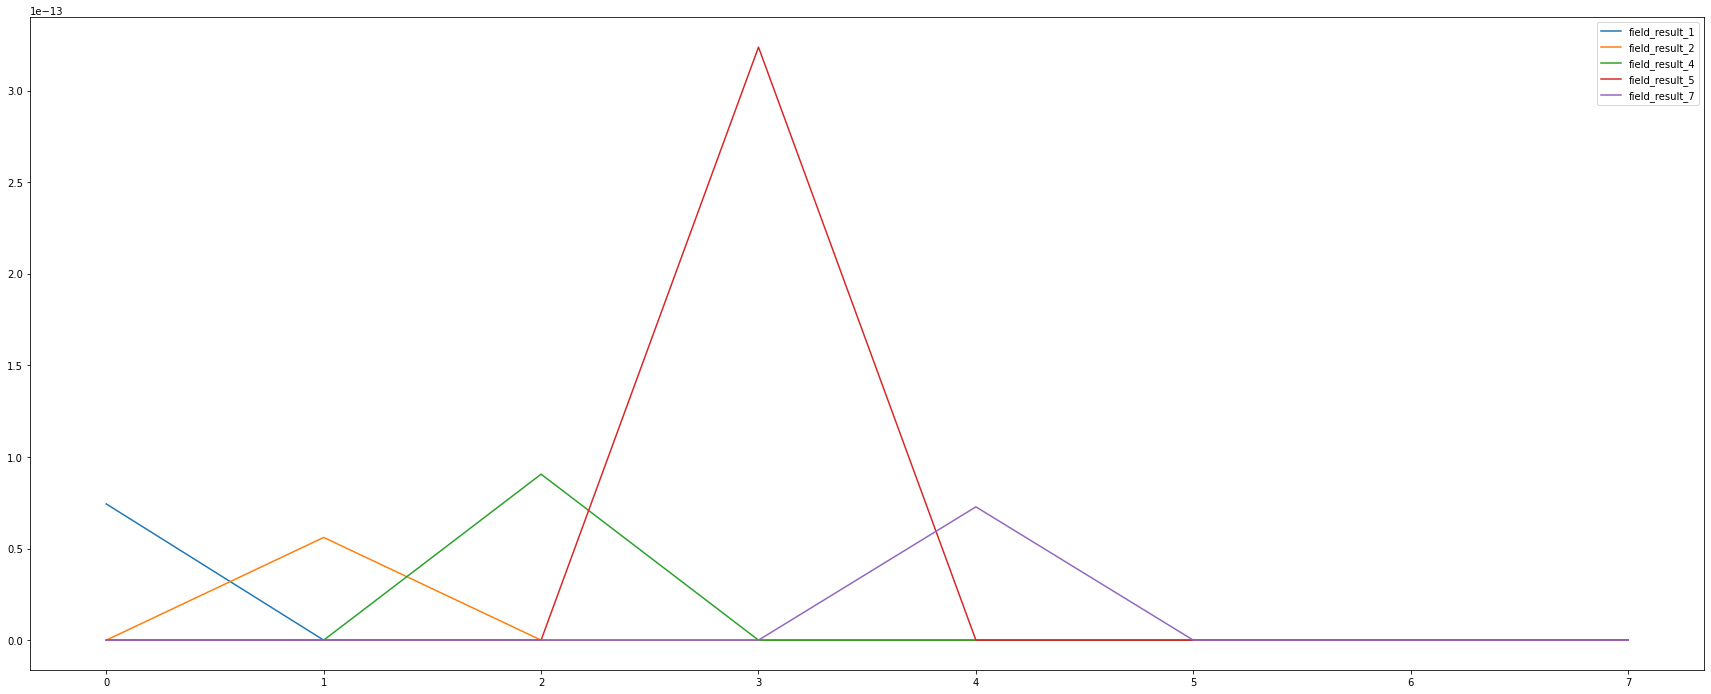

In [4]:
from expansion import spher_harm_expansion
###### loading in pickle file ###############################
# import data, and define parameters
#controlled electrodes- this will define which electrodes will be used to control your trap

size=20
soln_voltages = np.zeros((len(sim_list),18))
fig, ax = plt.subplots(figsize=(30, 12))

for i in np.arange(len(sim_list)):
    controlled_electrodes = []
    path = module_path+'/inter_results/field_result_'+str(sim_list[i])+'.pkl'
    print(path)
    f = open(path, 'rb')
    trap = pickle.load(f)
    f.close()
    controlled_electrodes = []
    for electrode in strs:
        if electrode in excl and excl[electrode] != "gnd":
            trap['electrodes'][excl[electrode]]["potential"] = trap['electrodes'][excl[electrode]]["potential"] + \
                                                               trap['electrodes'][electrode]["potential"]
        elif electrode not in excl:
            controlled_electrodes.append(electrode)
    used_order1multipoles = ['Ex', 'Ey', 'Ez']
    used_order2multipoles = ['U1', 'U2', 'U3','U4','U5']
    used_multipoles = used_order1multipoles + used_order2multipoles
    s = MultipoleControl(trap, position, roi, controlled_electrodes, used_multipoles, order)
    
    #which multipoles you want to include in multipole calculations
    v1 = pd.Series(np.zeros(len(controlled_electrodes)), index=controlled_electrodes)
    vs = []
    for ele in s.electrode_names:
        v = v1.copy()
        v[ele] = 1
        vs.append(v)

    numMUltipoles = len(used_multipoles)
    Coeffs = pd.DataFrame()
    s.update_origin_roi(r0, roi)
    m0 = True
    norm_list = np.zeros(len(used_multipoles))
    for key in used_multipoles:
        multipole_coeffs = pd.Series(np.zeros(len(used_multipoles)), index=used_multipoles)
        multipole_coeffs[key] = 1
        voltages = s.setMultipoles(multipole_coeffs)
        Mj,Yj,scale = spher_harm_expansion(sfinal.potentialControl_roi(voltages), r0,
                                           sfinal.X_roi,sfinal.Y_roi,sfinal.Z_roi, order)
        generated = np.zeros(9)
        generated[0] = Mj[0]
        generated[1] = Mj[3]
        generated[2] = Mj[1]
        generated[3] = Mj[2]
        generated[4] = Mj[8]
        generated[5] = Mj[6]
        generated[6] = Mj[4]
        generated[7] = Mj[5]
        generated[8] = Mj[7]
        if m0:
            norm_list[i]=np.linalg.norm(multipole_coeffs-generated[1:9])
        m0 = False
    ax.plot(norm_list,label="field_result_"+str(sim_list[i]))
#     ax.set_ylim(0,2)
    ax.legend()
#         ax1.set_xticklabels(s.multipole_names, rotation=-90, fontsize=10)

